In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\rukmangadan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data(in_file):
    SM_ML_df = pd.read_excel(in_file, sheet_name='SM_ML_values')
    reqd_data_arr = ['Plot_Id', 'Crop_Type', 'Field_SM', 'rsm_VATI', 'max_RSM', 'Soil_Class']
    SM_ML_df = SM_ML_df[reqd_data_arr]
    SM_ML_df.replace(0, np.nan, inplace=True)
    SM_ML_df.replace(-np.inf, np.nan, inplace=True)
    SM_ML_df = SM_ML_df.dropna(axis=0, how='any')
    return SM_ML_df

def replace_df_with_crop_classes_andMaptoInt(basepath, SM_ML_df):
    # Replacing with crop classes
    crop_class_file = basepath + 'd_crop_classes.xlsx'
    crop_class_df = pd.read_excel(crop_class_file, sheet_name='crop_classes')
    # print (crop_class_df)

    replacing_dict = {}
    for index, each_row in crop_class_df.iterrows():
    #     print (each_row, type(each_row))
        replacing_dict[each_row['Crop_Type']] = 'class' + str(each_row['Crop_Class'])
#     print (replacing_dict)

    SM_ML_df["Crop_Type"] = SM_ML_df["Crop_Type"].str.strip().replace(replacing_dict)
    # print (SM_ML_df)

    # Forming Dictionary for crop Type and replacing with integer in Crop Type Column
    Crop_Type_nparray = np.sort(SM_ML_df['Crop_Type'].str.strip().unique())
#     print (Crop_Type_nparray)

    int_toCrop_type_dict = dict(enumerate(Crop_Type_nparray))
    crop_type_toInt_dict = {y:(x+1) for x,y in int_toCrop_type_dict.items()}
#     print (int_toCrop_type_dict)
#     print(crop_type_toInt_dict)

    SM_ML_df["Crop_Type"] = SM_ML_df["Crop_Type"].str.strip().map(crop_type_toInt_dict)
#     print (SM_ML_df)
#     print(SM_ML_df['Crop_Type'].unique())
#     print(SM_ML_df['Soil_Class'].unique())
    return SM_ML_df

def make_data_ready(SM_ML_df):
    X = SM_ML_df[['Crop_Type', 'rsm_VATI', 'max_RSM', 'Soil_Class']]
    y = SM_ML_df[['Field_SM']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train, y_test
    return (X_train, X_test, y_train, y_test)

In [3]:
# basepath = 'C:\\Users\\soi\\Documents\\MTECH-PROJ-Phase-2\\'
basepath = 'C:\\Users\\rukmangadan\\Documents\\MTECH-PROJ-Phase-2\\'
# basepath = 'C:\\Users\\theorist\\Documents\\MTECH-PROJ-Phase-2\\'
in_file = basepath + 'd_soil_moisture_comparison_data.xlsx'
SM_ML_df = load_data(in_file)
SM_ML_df = replace_df_with_crop_classes_andMaptoInt(basepath, SM_ML_df)
#     print(SM_ML_df)
X_train, X_test, y_train, y_test = make_data_ready(SM_ML_df)

In [33]:
def tnsrflw(train_input, y_train, test_input, optimizer_type, epochs):
    train_output = y_train.values.flatten()
    
    A = tf.placeholder("float", [None, 4])
    Y = tf.placeholder("float", [None, 1])
    
    layer_1 = tf.layers.dense(A, 256)
    layer_2 = tf.layers.dense(layer_1, 256)
    layer_3 = tf.layers.dense(layer_2, 256)
    layer_4 = tf.layers.dense(layer_3, 256)
    layer_5 = tf.layers.dense(layer_4, 256)
    pred = tf.layers.dense(layer_5, 1)
    
    cost = tf.reduce_max(tf.square(pred - Y))
    optimizer = optimizer_type.minimize(cost)
    
    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    
    step = 0
    total_steps = train_input.shape[0] * epochs
    for epoch in range(epochs):
        for (x, y) in zip(train_input, train_output):
            sess.run(optimizer, feed_dict={A:[[x[0],x[1],x[2],x[3]]], Y:[[y]]})
            if(step % (total_steps/4) == 0):
                print("Step", step, "of", total_steps, ":")
                print ("Cost: ",sess.run(cost, feed_dict={A:np.transpose([train_input[:,0],train_input[:,1],train_input[:,2],train_input[:,3]]), Y:np.transpose([train_output])}),"\n")
            step+=1
    
    print("Step", total_steps, "of", total_steps, ":")
    print ("Cost: ",sess.run(cost, feed_dict={A:np.transpose([train_input[:,0],train_input[:,1],train_input[:,2],train_input[:,3]]), Y:np.transpose([train_output])}),"\n")
    
    y_pred_test = sess.run(pred, feed_dict={A:np.transpose([test_input[:,0],test_input[:,1],test_input[:,2],test_input[:,3]])})
    y_pred_train = sess.run(pred, feed_dict={A:np.transpose([train_input[:,0],train_input[:,1],train_input[:,2],train_input[:,3]])})
    
    sess.close()
    return y_pred_test, y_pred_train

In [ ]:
optimizer_type = tf.train.AdamOptimizer(0.001)
epochs = 1000
y_pred_test, y_pred_train = tnsrflw(X_train, y_train, X_test, optimizer_type, epochs)

Step 0 of 682000 :
Cost:  11337.722 



In [35]:
def plot_y_vs_y_predicted(y_actual, y_pred):
    y_actual_val = y_actual.values.flatten()
    v = [0, 40, 0, 40]
    plt.axis(v)
    plt.scatter(y_actual_val, y_pred)
    plt.xlabel("Y_Actual")
    plt.ylabel("Y_Predicted")
    plt.show()
    
def number_of_points_statistics(y_test, y_pred_test, y_train, y_pred_train):
    y_test_val = y_test.values.flatten()
    y_train_val = y_train.values.flatten()
    no_of_points_above = 0
    no_of_points_matching = 0
    no_of_points_below = 0
    
    for Y1, Y2 in zip(y_test_val, y_pred_test):
        if(0.7 * Y2 < Y1 and Y1 < 1.3 * Y2):
            no_of_points_matching += 1
        elif (Y1 < Y2):
            no_of_points_above += 1
        elif (Y2 < Y1):
            no_of_points_below += 1
    
    for Y1, Y2 in zip(y_train_val, y_pred_train):
        if(0.7 * Y2 < Y1 and Y1 < 1.3 * Y2):
            no_of_points_matching += 1
        elif (Y1 < Y2):
            no_of_points_above += 1
        elif (Y2 < Y1):
            no_of_points_below += 1
    
    print("no_of_points_matching: ", no_of_points_matching)
    print("no_of_points_above: ", no_of_points_above)
    print("no_of_points_below: ", no_of_points_below)

no_of_points_matching:  225
no_of_points_above:  330
no_of_points_below:  203
Test Data Graph:


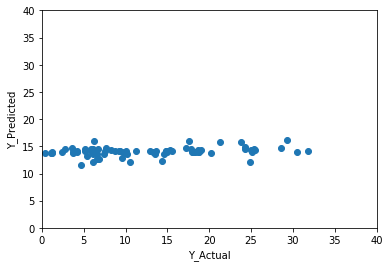

Trained Data Graph:


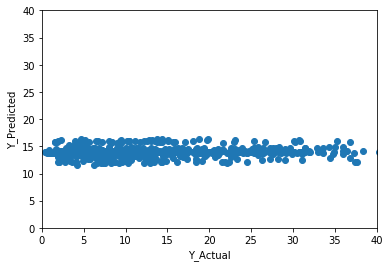

In [36]:
number_of_points_statistics(y_test, y_pred_test, y_train, y_pred_train)
print("Test Data Graph:")
plot_y_vs_y_predicted(y_test, y_pred_test)
print("Trained Data Graph:")
plot_y_vs_y_predicted(y_train, y_pred_train)